# GenomeVAE

This code will train a genomeVAE model

Each genome has both a tla and tnum that can be used to identify it

tla = three letter abbreviation = genome ID, tnum = T number = genome ID

KO and gene are used interchangeably

In [ ]:
## TO DO:
# org_to_mod_to_kos -> tla_to_mod_to_kos
# org_to_kos -> tnum_to_kos

### Load libraries, format settings

In [1]:
# automatically upload modules
%load_ext autoreload
%autoreload 2

In [2]:
from argparse import Namespace
from collections import defaultdict
import random
import re
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import ray
from ray import tune
from scipy import stats
import sklearn as sk
import torch

from genome_embeddings import corrupt
from genome_embeddings import data_viz
from genome_embeddings import evaluate
from genome_embeddings import models
from genome_embeddings import pathways
from genome_embeddings import pre_process
from genome_embeddings import trainable 

loaded train + test data


In [14]:
mode = "Desktop" # "CC" | "Desktop"
# must change local_dir="/Users/natasha/Desktop/TUNE_RESULT_DIR"
#local_dir="/home/ndudek/projects/def-dprecup/ndudek/hp_tuning_04-12-2020/TUNE_RESULT_DIR"

BASE_DIR = '/Users/natasha/Desktop/vae/'
DATA_DIR = '/Users/natasha/Desktop/mcgill_postdoc/ncbi_genomes/kegg_dataset/'
replacement_threshold = 0.5 # probability over which binarizer converts to a 1   

# Load dataset

In [29]:
tla_to_tnum, tnum_to_tla, keepers = pre_process.genomes2include(DATA_DIR)
tnum_to_kos, n_kos_tot, all_kos = pre_process.load_kos(tla_to_tnum, tnum_to_tla, tla_to_mod_to_kos, DATA_DIR)
org_to_mod_to_kos, mod_sets = pre_process.load_mods(DATA_DIR)
mod_to_kos = pre_process.create_mod_to_kos(org_to_mod_to_kos)

Total number of KOs in dataset: 9874


In [30]:
len(tla_to_tnum)

2718

In [20]:
all_kos = torch.load(BASE_DIR+"all_kos_2020-09-29.pt")
tla_to_mod_to_kos = torch.load(BASE_DIR+"tla_to_mod_to_kos_2020-09-29.pt")
train_data = torch.load(BASE_DIR+"kegg_v2_train_2020-09-29.pt")
test_data = torch.load(BASE_DIR+"kegg_v2_test_2020-09-29.pt")
train_genomes = torch.load(BASE_DIR+"kegg_v2_train_genomes_2020-09-29.pt")
test_genomes = torch.load(BASE_DIR+"kegg_v2_test_genomes_2020-09-29.pt")

# Filter dataset

In [31]:
# Remove any genomes with fewer than n_min KOs (endosymbionts)
n_min = 500
train_data, test_data, train_genomes, test_genomes = pre_process.filter(n_min, train_data, test_data, 
                                                                        train_genomes, test_genomes)

In [32]:
len(train_data), len(test_genomes)

(2332, 282)

In [33]:
# get rid of genomes that encode fewer than n_mods modules
n_mods = 10
train_data, train_genomes = pre_process.remove_duds(train_data, train_genomes, tnum_to_tla, tla_to_mod_to_kos, n_mods)
test_data, test_genomes = pre_process.remove_duds(test_data, test_genomes, tnum_to_tla, tla_to_mod_to_kos, n_mods)

In [36]:
# Are there any columns that are all zeros in both the train and test sets (TL;DR yes)
# Get rid of those ---> adjust train_data, test_data, and all_kos
good_cols = ((train_data.sum(axis=0) != 0) | (test_data.sum(axis=0) != 0))
train_data = train_data[:,good_cols]
test_data = test_data[:,good_cols]
all_kos = np.array(all_kos)[good_cols].tolist()

In [37]:
# In just the training set, how many genomes and genes have zero entries (test set only)
(train_data.sum(axis=1) == 0).sum(), (train_data.sum(axis=0) == 0).sum()

(0, 77)

In [38]:
# In just the test set, how many genomes and genes have zero entries (training set only)
(test_data.sum(axis=1) == 0).sum(), (test_data.sum(axis=0) == 0).sum()

(0, 1595)

In [39]:
print("The training set consists of "+str(train_data.shape[0])+" genomes")
print("The test set consists of "+str(test_data.shape[0])+" genomes")
print("In total there are "+str(train_data.shape[0]+test_data.shape[0])+" genomes")
print("In total there are "+str(train_data.shape[1])+" genes")

The training set consists of 2305 genomes
The test set consists of 279 genomes
In total there are 2584 genomes
In total there are 9863 genes


# Data exploration

In [40]:
plt.rcParams.update({'font.size': 14})

73 401


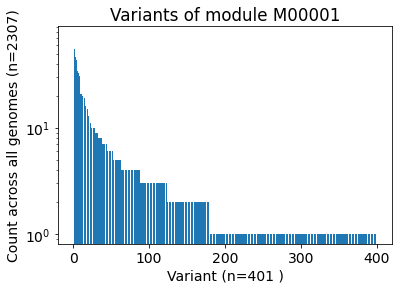

In [41]:
# Histogram showing variants of a given module across genomes in the full dataset
##### not filtered (mod_sets)
mod = 'M00001'
a = list(mod_sets[mod].values())
a.sort(reverse=True)
x_labels = [i for i in range(len(mod_sets[mod].values()))]
plt.bar(x_labels, a)
plt.yscale('log')
plt.title("Variants of module "+mod)
plt.xlabel("Variant (n="+str(len(mod_sets[mod].values()))+" )")
plt.ylabel("Count across all genomes (n="+str(len(tla_to_mod_to_kos))+")")
print(max(mod_sets[mod].values()), len(a))

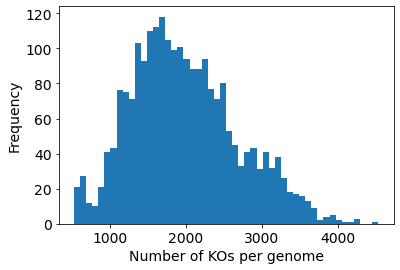

In [42]:
# Plot the number of KOs encoded by each genome in the full dataset
# Note: this includes genomes excluded from the final dataset
plt.hist([len(tnum_to_kos[i]) for i in tnum_to_kos], 50)
plt.xlabel("Number of KOs per genome")
plt.ylabel("Frequency")
plt.savefig(BASE_DIR+"fig.png")

In [43]:
# Median, min, and max # KOs per genome
lens = [len(tnum_to_kos[i]) for i in tnum_to_kos if i in train_genomes or i in test_genomes]
print("Median:",np.median(lens), "Min:",min(lens), "Max:",max(lens))

Median: 1907.0 Min: 528 Max: 4536


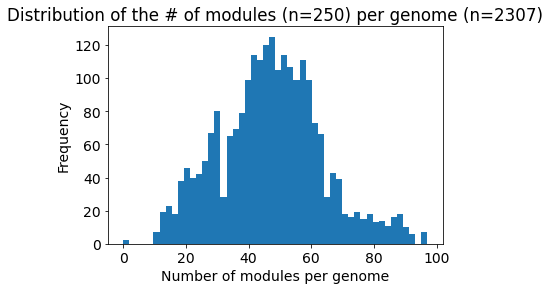

In [44]:
# Plot the number of modules encoded by each genome
fig = data_viz.mods_by_genomes(tla_to_mod_to_kos)

Number of mods encoded in only one genome: 25
Max number of genomes encoding a single mod 2285


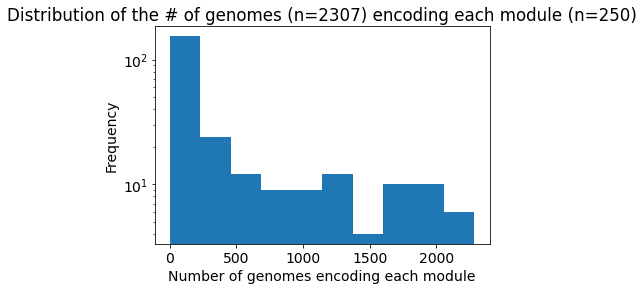

In [45]:
# Count and plot the number of genomes that encode each module
# This is for the whole dataset
mods_count = defaultdict(int)
org_count = 0
for org in tla_to_mod_to_kos:
    for mod in tla_to_mod_to_kos[org]:
        mods_count[mod] += 1
    org_count += 1
        
plt.hist(mods_count.values(), 10)
plt.xlabel("Number of genomes encoding each module")
plt.ylabel("Frequency")
plt.title("Distribution of the # of genomes (n="+str(org_count)+") encoding each module (n="+str(len(mods_count))+")")
plt.yscale('log')
print("Number of mods encoded in only one genome:",list(mods_count.values()).count(1))
print("Max number of genomes encoding a single mod", max(list(mods_count.values())))

In [46]:
# # Plot the percentage of genes per genome that contribute to modules
# perc_mod = []
# for org in tla_to_mod_to_kos:
#     try:
#         tla = tla_to_tnum[org]
#         n_kos = len(tnum_to_kos[tla])
#         n_mod_kos = len([tla_to_mod_to_kos[org][mod] for mod in tla_to_mod_to_kos[org]])
#         perc_mod.append(n_mod_kos/n_kos*100)
#     except: KeyError

# plt.hist(perc_mod, 50)
# plt.xlabel("Percent of KOs contributing to modules")
# plt.ylabel("Frequency")
# plt.title("Distribution of the % of KOs (n_all="+str(n_kos_tot)+") represented by modules (n="+str(n_mods)+") per genome (n="+str(n_genomes)+")")


In [47]:
# # Percentage of KOs that are / are not part of a module

# kos_in_mods = []

# for org in tla_to_mod_to_kos:
#     for mod in tla_to_mod_to_kos[org]:
#         kos_in_mods.extend(tla_to_mod_to_kos[org][mod])

# kos_in_mods = list(set(kos_in_mods))

# print(len(kos_in_mods), len(all_kos), len(kos_in_mods)/len(all_kos)*100)

In [48]:
# # Number of KOs that are part of 1 module, 2 modules, 3 modules, etc
# #all_kos # unique list of all KOs
# ko_counter = defaultdict(list)

# for ko in all_kos:
#     for org in tla_to_mod_to_kos:
#         for mod in tla_to_mod_to_kos[org]:
#             if ko in tla_to_mod_to_kos[org][mod]:
#                 if mod not in ko_counter[ko]:
#                     ko_counter[ko].append(mod)

In [49]:
# ko_counter2 = {}
# for ko in ko_counter:
#     ko_counter2[ko] = len(ko_counter[ko])

# for ko in all_kos:
#     if ko not in ko_counter2:
#         ko_counter2[ko] = 0

In [50]:
# a = defaultdict(int)
# for i in ko_counter2.values():
#     a[i] += 1
# a, sum(a.values())

In [51]:
# plt.hist(ko_counter2.values())
# plt.yscale('log')
# plt.title("Number of modules each KO contributes to")
# plt.xlabel("Number of modules")
# plt.ylabel("Frequency (# of KOs)")

# Corrupt input genomes

In [52]:
# corrupt version 1 -- extreme corruption
# 2020-09-04: select 1-10 mods for input
# 2020-10-16_10mods: select 10 mods for input, genomes with fewer than 10 mods are eliminated
# 2020-10-16_1mods: select 1 mods for input, genomes with fewer than 10 mods are eliminated 

new_corrupt = False
n_corrupt = 100
date_to_save = "2021-01-05_"+str(n_mods)+"mods"
date_to_load = "2021-01-05_10mods"

if new_corrupt:
    print ("Creating new corruptions")
    print (str(n_corrupt),"corruptions per genome")
    print ("With",str(n_mods),"modules as input per genome")
    print ("Saved as",date_to_save)
    #tnum_to_tla = {v:k for k,v in tla_to_tnum.items()}
    corrupted_train, c_train_genomes, train_input_mods = corrupt.corrupt(train_data, train_genomes, n_corrupt, tnum_to_tla, tla_to_mod_to_kos, all_kos, mod_to_ko_clean, org_to_kos, n_mods)
    corrupted_test, c_test_genomes, test_input_mods = corrupt.corrupt(test_data, test_genomes, n_corrupt, tnum_to_tla, tla_to_mod_to_kos, all_kos, mod_to_ko_clean, org_to_kos, n_mods)
    torch.save(corrupted_train, BASE_DIR+"corrupted_train_"+date_to_save+".pt")
    torch.save(c_train_genomes, BASE_DIR+"c_train_genomes_"+date_to_save+".pt")
    torch.save(corrupted_test, BASE_DIR+"corrupted_test_"+date_to_save+".pt")
    torch.save(c_test_genomes, BASE_DIR+"c_test_genomes_"+date_to_save+".pt")
    torch.save(train_input_mods, BASE_DIR+"train_input_mods_"+date_to_save+".pt")
    torch.save(test_input_mods, BASE_DIR+"test_input_mods_"+date_to_save+".pt")
else:
    print("Loading "+date_to_load)
    corrupted_train = torch.load(BASE_DIR+"corrupted_train_"+date_to_load+".pt")
    c_train_genomes = torch.load(BASE_DIR+"c_train_genomes_"+date_to_load+".pt")
    corrupted_test = torch.load(BASE_DIR+"corrupted_test_"+date_to_load+".pt")
    c_test_genomes = torch.load(BASE_DIR+"c_test_genomes_"+date_to_load+".pt")
    train_input_mods = torch.load(BASE_DIR+"train_input_mods_"+date_to_load+".pt")
    test_input_mods = torch.load(BASE_DIR+"test_input_mods_"+date_to_load+".pt")
    
print ("done")

Loading 2021-01-05_10mods
done


In [53]:
# confirm that there are no all-zero rows
non_zero_idx = corrupted_train.sum(axis=1) > n_min
len(non_zero_idx), corrupted_train.shape[0]

(230500, 230500)

In [54]:
corrupted_train.shape, corrupted_test.shape

(torch.Size([230500, 19726]), torch.Size([27900, 19726]))

# Visualization of final datasets

In [ ]:
fig, labels, y3 = data_viz.plot_tax_dist(c_train_genomes, c_test_genomes, 'Desktop')
plt.savefig(BASE_DIR+"fig_dist.png", bbox_inches='tight')

In [ ]:
def get_lengths(c_genomes, tnum_to_kos):
    lens = []
    for i in list(set(c_genomes)):
        tnum = tla_to_tnum[i]
        lens.append(len(tnum_to_kos[tnum]))
    return lens

train_lens = get_lengths(c_train_genomes, tnum_to_kos)
test_lens = get_lengths(c_test_genomes, tnum_to_kos)

In [ ]:
# Plot the number of KOs encoded by each genome
fig, ax = plt.subplots()
plt.hist(train_lens, 50, color='#3385ff')
plt.hist(test_lens, 50, color='#bb99ff')
ax.legend(['Train', 'Test'])
plt.xlabel("# annotated genes / genome")
plt.ylabel("Count")
plt.ylim(0,125)
plt.xlim(min(train_lens),max(train_lens)+10)
plt.savefig(BASE_DIR+"fig_ko_dist.pdf", figsize=(370.336, 245.416), bbox_inches='tight')

In [ ]:
# How many modules are there per training genome?
from collections import defaultdict
mods_count = defaultdict(int)
for org in tla_to_mod_to_kos:
    if org in c_train_genomes:
        mods_count[org] = len(tla_to_mod_to_kos[org])
plt.hist(mods_count.values())
plt.xlabel('Number of modules')
plt.ylabel('Number of genomes')

# HPO w/ Ray Tune: Define and train network

In [ ]:
memory = 2000 * 1024 * 1024
object_store_memory = 200 * 1024 * 1024
driver_object_store_memory=100 * 1024 * 1024
ray.shutdown()
ray.init(local_mode=True, memory=memory, 
        object_store_memory=object_store_memory,
        driver_object_store_memory=driver_object_store_memory,
        num_cpus=10)

In [ ]:
config = {"num_epochs": 10,
         "kfolds": 10,
         "replacement_threshold": 0.5,
         "nn_layers": tune.choice([1, 2, 3, 4]),
         "batch_size": tune.choice([32, 64, 128, 256]),
          "lr": tune.loguniform(1e-4, 1e-1), 
          "weight_decay": tune.loguniform(1e-5, 1e-2) 
         }

In [ ]:
config_corruption = {"num_epochs": 10,
         "kfolds": 10,
         "replacement_threshold": 0.5,
         "nn_layers": 3,
         "batch_size": 128,
          "lr": 0.001, 
          "weight_decay": 0.1
         }

In [ ]:
analysis = tune.run(
    trainable.train_AE, 
    name="17_02_2021_40mods",
    config=config_corruption,
    verbose=2, 
    resources_per_trial={
            "cpu": 10,
            "gpu": 0
    },
    #num_samples=20,
    num_samples=1,
    queue_trials=True,
    local_dir="/Users/natasha/Desktop/TUNE_RESULT_DIR",
    #local_dir="/home/ndudek/projects/def-dprecup/ndudek/hp_tuning_01-10-2020/TUNE_RESULT_DIR"
    )

In [ ]:
# print("Best config is:", analysis.get_best_config(metric="test_f1"))

In [ ]:
# analysis.get_best_config(metric="test_f1")

# Single model: Define and train network

In [ ]:
# nn_layers = 3
# weight_decay = 0.1
# lr = 0.001
# batch_size = 128
# kfolds = 10
# num_epochs = 10
# replacement_threshold = 0.5

# kld0, bce0, train_losses, test_losses, train_f1s, test_f1s, model = trainable.train_single_vae(nn_layers, weight_decay, lr, batch_size, kfolds, num_epochs, replacement_threshold, corrupted_train, corrupted_test)


In [ ]:
# version = "0mod"
# torch.save(model.state_dict(), BASE_DIR+"_"+version+"_model.pt")

# torch.save(train_losses, BASE_DIR+"_"+version+"_train_losses.pt")
# torch.save(test_losses, BASE_DIR+"_"+version+"_test_losses.pt")
# torch.save(bce0, BASE_DIR+"_"+version+"_bce0.pt")
# torch.save(kld0, BASE_DIR+"_"+version+"_kld0.pt")
# torch.save(train_f1s, BASE_DIR+"_"+version+"_train_f1s.pt")
# torch.save(test_f1s, BASE_DIR+"_"+version+"_test_f1s.pt")

In [ ]:
load_model = True
version = "10mod"
if load_model:
    from genome_embeddings import models
    n_features = int(corrupted_train.shape[1]/2)
    model = models.VariationalAutoEncoder(n_features, 3)
    model.load_state_dict(torch.load(BASE_DIR+"_"+version+"_model.pt"))
    train_losses = torch.load(BASE_DIR+"_"+version+"_train_losses.pt")
    test_losses = torch.load(BASE_DIR+"_"+version+"_test_losses.pt")
    train_f1s = torch.load(BASE_DIR+"_"+version+"_train_f1s.pt")
    test_f1s = torch.load(BASE_DIR+"_"+version+"_test_f1s.pt")
    bce0 = torch.load(BASE_DIR+"_"+version+"_bce0.pt")
    kld0 = torch.load(BASE_DIR+"_"+version+"_kld0.pt")

# Evaluate model performance

### Generate predictions on test set

In [ ]:
# 1-10 modules per input genome: 0.74
# 1 module per input genome: 0.64
# 10 modules per input genome: 0.81
n_features = int(corrupted_test.shape[1]/2)
corrupted = corrupted_test[:,:n_features]
uncorrupted = corrupted_test[:,n_features:]

In [ ]:
new_preds = False

model.eval()

if new_preds:
    with torch.no_grad():
        pred = model.forward(corrupted)[0].detach()
    binary_pred = evaluate.eval_binarize(pred, 0.5)
    torch.save(pred, BASE_DIR+"_preds.pt")
    torch.save(binary_pred, BASE_DIR+"_binary_preds.pt")
else:
    pred = torch.load(BASE_DIR+"_preds.pt")
    binary_pred = torch.load(BASE_DIR+"_binary_preds.pt")

### Investigate test set F1 score (micro-average) and calculate TNs, FPs, FNs, TPs

In [ ]:
f1 = sk.metrics.f1_score(uncorrupted, binary_pred, zero_division=0, average='micro')
print("Test set F1 score",f1)

In [ ]:
f1s, fig = evaluate.test_f1s(uncorrupted, binary_pred)
plt.savefig(BASE_DIR+"f1_dist.pdf", bbox_inches='tight')

In [ ]:
tns, fps, fns, tps, total = evaluate.glom_confusion(uncorrupted, binary_pred)
print(round(sum(tns)/total*100,2), round(sum(fps)/total*100,2), round(sum(fns)/total*100,2), round(sum(tps)/total*100,2))


In [ ]:
tns[0]

### Examine at BCE vs KLD loss

In [ ]:
# Plot BCE and KLD vs experience
data_viz.kld_vs_bce(kld0,bce0)

### Plot learning curves

In [ ]:
fig = data_viz.learning_curve(train_losses, test_losses, train_f1s, test_f1s)
plt.savefig(BASE_DIR+"learning_curves.pdf", bbox_inches='tight')

### Plot ROC curve and generate AUC score (micro-average)

In [ ]:
num_features = int(corrupted_test.shape[1]/2)
true_genomes = corrupted_test[:,num_features:]
fig = data_viz.my_roc_curve(true_genomes.numpy(), pred.numpy())
fig.savefig(BASE_DIR+"roc_fig.pdf", dpi=200, bbox_inches='tight')

### Are the input genes present in the output?

In [ ]:
# relabel y axis by % rather than count
fig, _ = evaluate.compare_in_n_out(binary_pred, corrupted)
fig.savefig(BASE_DIR+"input_vs_output.pdf", bbox_inches='tight', dpi=200)

### What are the best and worst performing instances?

In [ ]:
# babt = Brucella abortus
idx_best = f1s.index(max(f1s))
tla_best = c_test_genomes[idx_best]
idx_best, tla_best, f1s[idx_best], tla_to_tnum[tla_best]

In [ ]:
# nmv = Nitrospira moscoviensis
# seny = Pectobacteriaceae sodalis (Gammaprot), endosymbiont of Henestaris halophilus
# bmx
idx_worst = f1s.index(min(f1s))
tla_worst = c_test_genomes[idx_worst]
idx_worst, tla_worst, f1s[idx_worst], tla_to_tnum[tla_worst]

### For the best scoring instance, plot pixel diagram

In [ ]:
idx = idx_best
fig = data_viz.genome_heatmap2(corrupted_test, idx, model, f1s, tns, fps, fns, tps, binary_pred)
fig.savefig(BASE_DIR+"fig4.pdf", bbox_inches='tight', dpi=200)

In [ ]:
print("Num genes on in uncorrupted idx_best genome", torch.sum(uncorrupted[idx_best,:]))
print("Num genes off in uncorrupted idx_best genome", n_features - torch.sum(uncorrupted[idx_best,:]))
print("Num genes on in corrupted idx_best genome", torch.sum(corrupted[idx_best,:]))

In [ ]:
fig = evaluate.snowplot(f1s, c_test_genomes, tns, fps, fns, tps, uncorrupted, corrupted, idx_best)
fig.savefig(BASE_DIR+"barh.pdf", bbox_inches='tight', dpi=200)

### For the worst scoring instance, plot pixel diagram

In [ ]:
idx = idx_worst
fig = data_viz.genome_heatmap2(corrupted_test, idx, model, f1s, tns, fps, fns, tps, binary_pred)
fig.savefig(BASE_DIR+"fig4.png", bbox_inches='tight', dpi=200)

In [ ]:
# print median TNs, FPs, FNs, TPs
np.median(tns), np.median(fps), np.median(fns), np.median(tps)

### How does the model perform on inputs originating from different phyla

In [ ]:
# get dicts to map genome tla back to list of phylum, class, etc
train_tax_dict, test_tax_dict = data_viz.tax_distribution(c_train_genomes, c_test_genomes, 'Desktop')

In [ ]:
count_per_phy = defaultdict(int)
for tnum in test_genomes:
    tla = tnum_to_tla[tnum]
    phylum = test_tax_dict[tla][1]
    if phylum == 'Proteobacteria':
        phylum = test_tax_dict[tla][2]
    count_per_phy[phylum] += 1
count_per_phy

In [ ]:
train_phyla, test_phyla = evaluate.f1s_per_phylum(train_tax_dict, test_tax_dict, c_test_genomes, f1s)

In [ ]:
# number of phyla in train + test sets
len(set(list(train_phyla.keys()) + list(test_phyla.keys())))

In [ ]:
# Bars represent median absolute deviation
fig_save_for_later = evaluate.plot_f1_per_phylum(test_phyla, (5,10))
fig_save_for_later.savefig(BASE_DIR+"f1_per_phylum.png", dpi=200, bbox_inches='tight')

In [ ]:
# Are the results between phyla statistically significant?
stats.kruskal(*test_phyla.values())

In [ ]:
fig = evaluate.plot_count_vs_f1s(train_phyla, test_phyla)

There appears to be an effect of number of training genomes / phylum on test set per phylum F1 score 

### How many times is each mod used in the various corrupted inputs?

In [ ]:
# Number of times each mod occurs in the training set corrupted genomes
train_out = evaluate.train_out(train_input_mods)

In [ ]:
fig = evaluate.plot_train_count_hist(train_out)

### How does genome size correlate with F1 score

In [ ]:
# x-axis = # genes in input genome
# y-axis = F1 score of reconstructed genomes

In [ ]:
n_genes_uncorrupted = torch.sum(uncorrupted, 1).numpy().tolist() # get sum of each row

In [ ]:
plt.scatter(n_genes_uncorrupted, f1s, marker='.', s = 1)
plt.xlabel("# genes in uncorrupted genome")
plt.ylabel("F1 score")

In [ ]:
n_genes_corrupted = torch.sum(corrupted, 1).numpy().tolist() # get sum of each row

In [ ]:
plt.scatter(n_genes_corrupted, f1s, marker='.', s = 1)
plt.xlabel("# genes in corrupted input")
plt.ylabel("F1 score")

### How much variance is there in the F1 score of genomes encoding certain modules?
Do some modules / lifestyles get reconstructed better than others?

In [ ]:
process_to_mod, mod_to_proc = evaluate.map_proc_mod()

In [ ]:
#fig, done = evaluate.plot_mod_count_vs_f1(test_input_mods, c_test_genomes, train_input_mods, f1s)

In [ ]:
#fig = evaluate.plot_mod_vs_f1(test_input_mods, f1s)

In [ ]:
# Plot whether number of modules in process correlates with F1 score
# More interchangeable options = worse performance?

In [ ]:
subprocess_to_mod, mod_to_subproc = evaluate.map_subproc_mod()

In [ ]:
# fig = evaluate.plot_metab_pathway_f1(subprocess_to_mod, test_input_mods, f1s)

### Analyze F1 scores of actual KOs

In [ ]:
### THIS MUST BE USED IN MULTIPLE PLACES
ko_f1s = []
for i in range(uncorrupted.shape[1]): # for every column
    f1 = sk.metrics.f1_score(uncorrupted[:,i], binary_pred[:,i], zero_division=0)
    ko_f1s.append(f1)

In [ ]:
zeros = 0
for i in ko_f1s:
    if i == 0:
        zeros += 1
print(zeros, len(ko_f1s), zeros/len(ko_f1s)*100)

In [ ]:
# In the training set, how many KOs are always zero?
zeros_train = train_data.sum(axis=0) > 0
n_ones = np.sum(zeros_train)
n_zeros_train = len(zeros_train) - n_ones
print("There are",n_zeros_train,"genes that are always off in the training set")

In [ ]:
fig = plt.figure()
plt.hist(ko_f1s, bins = 50)
plt.xlabel("F1 score per gene")
plt.ylabel("Count")

In [ ]:
# gene occurence in uncorrupted ds vs F1 score
#ko_counts = torch.sum(uncorrupted, 0)
# get gene occurence in uncorrupted training set
tr_uncorrupted = corrupted_train[:,n_features:]
ko_counts = torch.sum(tr_uncorrupted, 0)

fig, ax = plt.subplots()
plt.scatter(ko_counts, ko_f1s, marker='.', s = 1)
ax.set_xlim(0, tr_uncorrupted.shape[0])
ax.set_ylim(0,1)
plt.xlabel("gene count in uncorrupted train set")
plt.ylabel("per gene test F1 score")
plt.xticks(rotation=-70)
print("max KO count:",int(max(ko_counts)), ", total number of training genomes:",tr_uncorrupted.shape[0])

### Generate figure for paper

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(15, 5))

phylum_f1s = [np.median(test_phyla[i]) for i in test_phyla]
phylum_count = [train_phyla[i] for i in test_phyla]
ax1.scatter(phylum_count, phylum_f1s)
ax1.set_xlabel("Number of genomes in train set")
ax1.set_ylabel("F1 score on test set")
ax1.set_xscale('log')

tr_uncorrupted = corrupted_train[:,n_features:]
ko_counts = torch.sum(tr_uncorrupted, 0)
ax2.scatter(ko_counts, ko_f1s, marker='.', s = 1)
ax2.set_xlim(0, tr_uncorrupted.shape[0])
ax2.set_ylim(0,1)
ax2.set_xlabel("Gene count in uncorrupted train set")
ax2.set_ylabel("Ger gene test F1 score")

n_genes_uncorrupted = torch.sum(uncorrupted, 1).numpy().tolist() # get sum of each row
ax3.scatter(n_genes_uncorrupted, f1s, marker='.', s = 1)
ax3.set_xlabel("# genes in original test genome")
ax3.set_ylabel("F1 score on test set")

plt.tight_layout()

fig.savefig(BASE_DIR+"bio_insights_contd.pdf", dpi=200, bbox_inches='tight')

In [ ]:
# F1 score on KOs + what metab pathway they are part of

In [ ]:
fig = evaluate.plot_metab_pathway_f1_v2(process_to_mod, mod_to_ko_clean, all_kos, ko_f1s, (7,5))

In [ ]:
# can also do horizontal boxplot with fig = evaluate.plot_metab_pathway_f1_v2
fig, proc_to_ko_F1s = evaluate.plot_metab_pathway_f1_v2_horizontal(subprocess_to_mod, mod_to_ko_clean, all_kos, ko_f1s, (5,10))
#fig.savefig(BASE_DIR+"f1_per_proc.png", dpi=200, bbox_inches='tight')

In [ ]:
stats.kruskal(*proc_to_ko_F1s.values())

In [ ]:
### How does the model do on different types of genes (kinases vs transferases, etc) 

In [ ]:
fig = evaluate.bio_insights_fig(test_phyla, subprocess_to_mod, all_kos, ko_f1s, mod_to_ko_clean)
fig.savefig(BASE_DIR+"bio_insights_fig.pdf", dpi=200, bbox_inches='tight')

### How does the count of each mod in training set (pre-corruption) correlate with median F1 score

In [ ]:
fig = evaluate.plot_mod_count_vs_f1_v2(test_input_mods, f1s, train_out)

# Qualitatively compare distance of real vs generated genomes

In [ ]:
# Generate 100 genomes using random sets of 10 modules
new_genomes = False

if new_genomes:
    from datetime import date
    date = date.today()
    generated, generated_inputs = evaluate.generate_genomes(100, all_kos, mod_to_ko_clean, 10, model)
    torch.save(generated, BASE_DIR+"generated_genomes_"+str(date)+".pt")
    torch.save(generated_inputs, BASE_DIR+"generated_genome_inputs_"+str(date)+".pt")
else:
#     generated = torch.load(BASE_DIR+"generated_genomes_11_01_2020.pt")
#     generated_inputs = torch.load(BASE_DIR+"generated_genome_inputs_11_01_2020.pt")
    generated = torch.load(BASE_DIR+"generated_genomes_2021-02-01.pt")
    generated_inputs = torch.load(BASE_DIR+"generated_genome_inputs_2021-02-01.pt")

### Plot PCA of Jaccard similarity between genomes, using Hamming distances as a metric

In [ ]:
idx = random.randint(279, 379) # assumes 279 test genomes + 100 generated genomes, 0-indexed
#idx = 368 # pathogen
#idx = 282 # heme biosyn
idx = 292
gen_idx = idx - test_data.shape[0] # generated genomes follow test set genomes in tensor
print("idx",str(idx),"Num genes in selected genome", int(torch.sum(generated[gen_idx])))
plt.rcParams.update({'font.size': 12})
#fig = evaluate.plot_dist(generated_genomes, all_kos, mod_to_ko_clean, model, test_data)
fig = evaluate.plot_dist(generated, all_kos, mod_to_ko_clean, model, test_data, idx)
fig.savefig(BASE_DIR+"pca_jaccard.pdf", dpi=200, bbox_inches='tight');

In [ ]:
gen_corrupted = np.zeros((len(generated_inputs), n_features))

for i in range(len(generated_inputs)):
    kos_in = generated_inputs[i][1] # get KOs used as inputs
    ko_idx = [all_kos.index(i) for i in kos_in] # get col index of those KOs in the data tensor
    gen_corrupted[i][ko_idx] = 1 # turn on genes at those indices

gen_corrupted = torch.Tensor(gen_corrupted).type(torch.LongTensor)

In [ ]:
fig, out = evaluate.compare_in_n_out(generated, gen_corrupted)

In [ ]:
len(generated_inputs)

In [ ]:
# Make list of KOs in generated genome
gen_ko_idx = [int(i) for i in (generated[gen_idx] == 1).nonzero()]
gen_kos = [all_kos[i] for i in gen_ko_idx]
len(gen_kos)

In [ ]:
# Assess ribosomal completeness
pathways.confirm_ribosome(gen_kos)

In [ ]:
# Assess rRNA gene completeness
pathways.confirm_rrna(gen_kos)

In [ ]:
assert 'K21254' in gen_kos

In [ ]:
# for each mod number, get its name
mod_to_name = pre_process.mod_names()

In [ ]:
def mod_completeness(genome_vector, mod_to_ko_clean, mod):
    count = 0
    for i in mod_to_ko_clean[mod]:
        if i in genome_vector:
            count += 1
        else:
            print("missing", i)
    print(count,"/",len(mod_to_ko_clean[mod]),"genes in the mod are present")

In [ ]:
for mod in generated_inputs[gen_idx][0]:
    print(mod, mod_to_name[mod])
    print(mod_to_ko_clean[mod])
    mod_completeness(gen_kos, mod_to_ko_clean, mod)
    print("--------------------------------------------")

In [ ]:
save_to = BASE_DIR+"prot_out_"+str(gen_idx)+".txt"

with open(BASE_DIR+'seq_dict.pkl', 'rb') as handle:
    seq_dict = pickle.load(handle)

with open(save_to, 'w') as handle:
    for prot in gen_kos:
        handle.write(">"+prot+"\n")
        handle.write(seq_dict[prot]+"\n")

print(gen_idx)

In [ ]:
# Prepare input to KEGG Mapper
for i, ko in enumerate(gen_kos):
    print("gene"+str(i), ko)

### Distributions of genes and modules per genome for real vs generated genomes

In [ ]:
def complete_mods(generated, all_kos, mod_to_ko_clean):
    gen_kos = defaultdict(list)
    for i, row in enumerate(generated):
        for j in range(len(row)):
            if row[j] == 1:
                gen_kos[i].append(all_kos[j])

    gen_mods = defaultdict(list)
    for genome in gen_kos:
        my_kos = gen_kos[genome]

        for mod in mod_to_ko_clean:
            complete = True
            for ko in mod_to_ko_clean[mod]:
                if ko not in my_kos: 
                    complete = False

            if complete:
                gen_mods[genome].append(mod)
                
    return gen_mods

In [ ]:
def mod_freqs(mod_to_ko_clean, test_data, generated):

    real_mod_freq = []
    gen_mod_freq = []
    for mod in mod_to_ko_clean:
        real_count = 0
        gen_count = 0
        for genome in gen_mods:
            if mod in gen_mods[genome]:
                gen_count += 1
            if mod in real_mods[genome]:
                real_count += 1
        real_mod_freq.append(real_count / len(test_data))
        gen_mod_freq.append(gen_count / len(generated))

    # sort in descending order of real genome mods
    real_mod_freq, gen_mod_freq = zip(*sorted(zip(real_mod_freq, gen_mod_freq), reverse=True))

    return real_mod_freq, gen_mod_freq

In [ ]:
gen_mods = complete_mods(generated, all_kos, mod_to_ko_clean)
real_mods = complete_mods(test_data, all_kos, mod_to_ko_clean)
gen_mod_lens = [len(gen_mods[i]) for i in gen_mods]
real_mod_lens = [len(real_mods[i]) for i in gen_mods]

real_mod_freq, gen_mod_freq = mod_freqs(mod_to_ko_clean, test_data, generated)
labels = [i for i in range(len(gen_mod_freq))]

len_gen = []
for genome in generated:
    len_gen.append(torch.sum(genome))
len_real = []
for genome in test_data:
    len_real.append(np.sum(genome))

In [ ]:
plt.rcParams.update({'font.size': 18})
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15,5))
#plt.yticks(fontsize=20) 

# Plot number of genes per genome
ax1.hist(len_real, 50, color='g', alpha=0.5)
ax1.hist(len_gen, 50, color='b', alpha=0.5)
#ax1.legend(['Real', 'Generated'])
ax1.set_xlabel("Number of genes")
ax1.set_ylabel("Genome count")

# Plot number of complete mods per genome
ax2.hist(gen_mod_lens, 50, color='b', alpha=0.5)
ax2.hist(real_mod_lens, 50, color='g', alpha=0.5)
#ax2.legend(['Real', 'Generated'])
ax2.set_xlabel("Number of complete modules")
ax2.set_ylabel("Genome count")

# Plot the fraction of genomes encoding each mod
ax3.bar(labels, gen_mod_freq, color='b', alpha=0.5)
ax3.bar(labels, real_mod_freq, color='g', alpha=0.5)
ax3.legend(['Real', 'Generated'])
ax3.set_xlabel("Module")
ax3.set_ylabel("Fraction of genomes \n encoding module")
ax3.set_xlim(0,len(labels))

plt.tight_layout()

fig.savefig(BASE_DIR+"count_dists.pdf", dpi=200, bbox_inches='tight')
fig.savefig(BASE_DIR+"count_dists.png", dpi=200, bbox_inches='tight')

### Create files needed to infer and visualize a dendrogram based on gene prescence/abscence
Will use phylip to infer a parsimony-based dendrogram (mix program)

Will use iTOL for visualization (display, add colour strips, remove taxon labels)

In [ ]:
barc_vec = evaluate.arch_root(all_kos)

In [ ]:
# Reformat tensor for input to phylip
df = evaluate.df_for_phylip(generated, test_data, test_genomes, all_kos)
df = df.append(pd.DataFrame({col: [val] for col, val in zip(df.columns, barc_vec)}, ['outgroup_T04065']))
phylum_dict = evaluate.write_out_for_phylip(BASE_DIR, df, tnum_to_tla, test_tax_dict) # phylip_in.txt
#df.to_csv(BASE_DIR+'generated_genomes.csv', index = True)

In [ ]:
# Sanity check
same = True
for i in range(len(generated[13])):
    if int(df.iloc[292][i]) != int(generated[13][i]):
        same = False
same

In [ ]:
# Find "phylip-3.695-vol", double click "mix" program
# Enter file name with path to dir ---> delete space at the end of the file name

In [ ]:
# For parsimony dendrogram: generate real genomes' phylum-level colour strip file for iTOL 
phyla_colours = evaluate.get_phyla_colours()
evaluate.colour_real_itol(BASE_DIR, phyla_colours, phylum_dict) # vae_dendro_colours_real.txt
#colour = tuple(np.random.randint(256, size=3))

In [ ]:
# For parsimony dendrogram: generate generated genomes' colour strip file for iTOL
evaluate.colour_generated_itol(BASE_DIR, phylum_dict) # vae_dendro_colours_generated.txt

# Baseline models

In [ ]:
import sklearn as sk
from sklearn.metrics import confusion_matrix

### Baseline 1: randomly turn on n_rand bits

In [ ]:
new = False

if new:
    print("Generating new baseline 1")
    baseline1 = evaluate.baseline1(corrupted_train, tla_to_mod_to_kos, tnum_to_kos, tla_to_tnum, c_train_genomes, corrupted_test)
    torch.save(baseline1, BASE_DIR+"baseline1.pt")
else:
    print("Loading previously made baseline 1")
    baseline1 = torch.load(BASE_DIR+"baseline1.pt")

In [ ]:
baseline1.shape

In [ ]:
f1 = sk.metrics.f1_score(uncorrupted, baseline1, zero_division=0, average='micro')
f1

In [ ]:
tns, fps, fns, tps, total = evaluate.glom_confusion(uncorrupted, baseline1)
print(round(sum(tns)/total*100,2), round(sum(fps)/total*100,2), round(sum(fns)/total*100,2), round(sum(tps)/total*100,2))


In [ ]:
# Plot ROC curve, generate AUC score (micro-average)
num_features = int(corrupted_test.shape[1]/2)
fig = data_viz.my_roc_curve(uncorrupted.numpy(), baseline1.numpy())

### Baseline 2: randomly turn on n_rand bits with the highest probability of being on across the entire training set

In [ ]:
new = True

if new:
    print("Generating new baseline 2")
    baseline2 = evaluate.baseline2(corrupted_test, tla_to_mod_to_kos, tnum_to_kos, tla_to_tnum, c_train_genomes, corrupted_test)
    torch.save(baseline2, BASE_DIR+"baseline2.pt")
else:
    print("Loading previously made baseline 2")
    baseline2 = torch.load(BASE_DIR+"baseline2.pt")
    

In [ ]:
f1 = sk.metrics.f1_score(uncorrupted, baseline2, zero_division=0, average='micro')
f1

In [ ]:
tns, fps, fns, tps, total = evaluate.glom_confusion(uncorrupted, baseline2)
print(round(sum(tns)/total*100,2), round(sum(fps)/total*100,2), round(sum(fns)/total*100,2), round(sum(tps)/total*100,2))


In [ ]:
# Plot ROC curve, generate AUC score (micro-average)
num_features = int(corrupted_test.shape[1]/2)
fig = data_viz.my_roc_curve(uncorrupted.numpy(), baseline2.numpy())

### Baseline 3: Create predictions using an untrained version of the VAE model

In [ ]:
new = True

if new:
    print("Generating new baseline 3")
    n_features = int(corrupted_test.shape[1]/2)
    fake_model = models.VariationalAutoEncoder(n_features, 3)
    fake_model.eval()
    with torch.no_grad():
        pred = fake_model.forward(corrupted_test[:,:n_features])[0].detach()
    baseline3 = evaluate.eval_binarize(pred, 0.5)
    torch.save(baseline3, BASE_DIR+"baseline3.pt")
else:
    print("Loading previously made baseline 3")
    baseline3 = torch.load(BASE_DIR+"baseline3.pt")

In [ ]:
f1 = sk.metrics.f1_score(uncorrupted.long(), baseline3.long(), zero_division=0, average='micro')
f1

In [ ]:
tns, fps, fns, tps, total = evaluate.glom_confusion(uncorrupted, baseline3)
print(round(sum(tns)/total*100,2), round(sum(fps)/total*100,2), round(sum(fns)/total*100,2), round(sum(tps)/total*100,2))


In [ ]:
# Plot ROC curve, generate AUC score (micro-average)
num_features = int(corrupted_test.shape[1]/2)
fig = data_viz.my_roc_curve(uncorrupted.numpy(), baseline3.numpy())

### Baseline 4: Always predict the smallest genome in the training set (Hoaglandella endobia -- hed)

In [ ]:
new = True

if new:
    print("Generating new baseline 4")
    baseline4 = evaluate.baseline4(corrupted_train, corrupted_test, tla_to_tnum, tnum_to_kos, c_train_genomes)
    torch.save(baseline4, BASE_DIR+"baseline4.pt")
else:
    print("Loading previously made baseline 4")
    baseline4 = torch.load(BASE_DIR+"baseline4.pt")

In [ ]:
f1 = sk.metrics.f1_score(uncorrupted, baseline4, zero_division=0, average='micro')
f1

In [ ]:
tns, fps, fns, tps, total = evaluate.glom_confusion(uncorrupted, baseline4)
print(round(sum(tns)/total*100,2), round(sum(fps)/total*100,2), round(sum(fns)/total*100,2), round(sum(tps)/total*100,2))


In [ ]:
# Plot ROC curve, generate AUC score (micro-average)
num_features = int(corrupted_test.shape[1]/2)
fig = data_viz.my_roc_curve(uncorrupted.numpy(), baseline4.numpy())

### Baseline 5: Always predict the largest genome in the training set (Paraburkholderia caribensis -- bcai)

In [ ]:
new = True

if new:
    print("Generating new baseline 5")
    baseline5, largest_tla = evaluate.baseline5(corrupted_train, corrupted_test, tla_to_tnum, tnum_to_kos, c_train_genomes)
    torch.save(baseline5, BASE_DIR+"baseline5.pt")
else:
    print("Loading previously made baseline 5")
    baseline5 = torch.load(BASE_DIR+"baseline5.pt")

In [ ]:
f1 = sk.metrics.f1_score(uncorrupted, baseline5, zero_division=0, average='micro')
f1

In [ ]:
tns, fps, fns, tps, total = evaluate.glom_confusion(uncorrupted, baseline5)
print(round(sum(tns)/total*100,2), round(sum(fps)/total*100,2), round(sum(fns)/total*100,2), round(sum(tps)/total*100,2))


In [ ]:
# Plot ROC curve, generate AUC score (micro-average)
num_features = int(corrupted_test.shape[1]/2)
fig = data_viz.my_roc_curve(uncorrupted.numpy(), baseline5.numpy())

# Potential model improvements

In [ ]:
# Increase dataset set (more corruptions per genome)
# For genomes it does poorly on, make more copies
# HP tuning
# Remove genomes with <1000 KOs ---> get rid of endosymbionts --- will need to redo small genome baseline
# Apply different amounts of KLD importance during training
# Make 100% of input genes in output (currently ~20% have 100% in and out). Loss mod?

In [ ]:
# We performed a parameter sweep over warmups (κ) (0.01, 0.05, 0.1, and 1). 
# κ controls how much the KL divergence loss contributes to learning, 
# which effectively transitions a deterministic autoencoder to a VAE.28,29 
# For instance, a κ = 0.1 would add 0.1 to a weight on the KL loss after each epoch. 
# After 10 epochs, the KL loss will have equal weight as the reconstruction loss. 
# We did not observe κ to influence model training (Figure 1B), so we kept κ = 1 for downstream analyses.

# Model output to KAAS input

In [ ]:
# generate NEW genome from 10 random modules

######### ensure desired KOs are in output file --- did not happen when used above with tensor instead of df

save_to = BASE_DIR+'prot_out_'+str(gen_idx)+'.txt'
ko_new = evaluate.new_genome_random(mod_to_ko_clean, model, all_kos, save_to, BASE_DIR)

In [ ]:
gen_idx